# Overview of different model options

The purpose of this notebook is to provide a description of all the different model options `victor` provides. Refer to the `victor_usage_demo.ipynb` notebook for basic information on using `victor` first.

In [1]:
# Start with basic module imports
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
from victor import CCFModel, plottools

%matplotlib inline
plt.style.use('seaborn-talk')

# Setting up

For demonstration purposes in this notebook we use some special example data with paths and options specified in `config/example_model_input.yaml`:

In [2]:
top_level_dir = os.path.dirname(os.getcwd()) # to step back up from the current notebook directory

with open(os.path.join(top_level_dir, 'config/example_model_input.yaml')) as f:
    model = yaml.full_load(f)['model']

model['dir'] = top_level_dir
ccf = CCFModel(model)

Before starting we can visualize the input data:

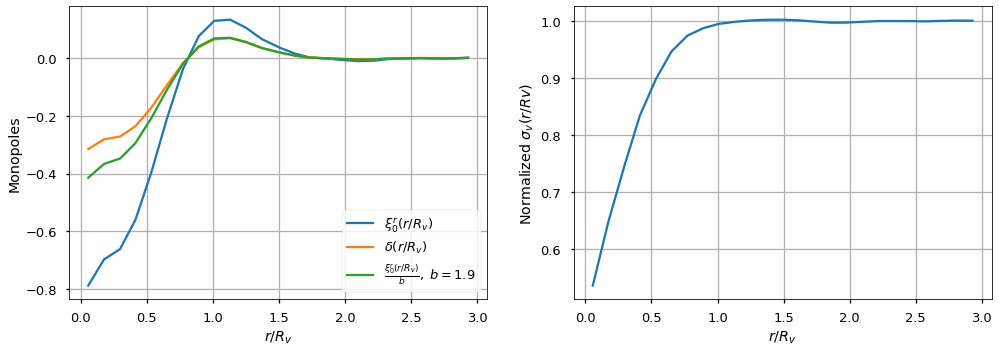

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ccf.plot_realspace_multipoles({'label': r'$\xi^r_0(r/R_v)$'}, ell=0, ax=ax1, **{'xlabel': r'$r/R_v$', 'ylabel': r'Monopoles'})
params = {} # empty dict used to satisfy the call signature
# get the default template matter ccf profile
delta, integ_delta = ccf.delta_profiles(ccf.r, params)
# override the default set during initialisation through kwargs and calculate matter ccf using linear bias approximation
bias_delta, bias_integ_delta = ccf.delta_profiles(ccf.r, params, **{'matter_model': 'linear_bias'}) 
ax1.plot(ccf.r, delta, label=r'$\delta(r/R_v)$')
ax1.plot(ccf.r, bias_delta, label=rf'$\frac{{\xi^r_0(r/R_v)}}{{b}},\;b={model["matter_ccf"]["bias"]}$')
ax1.legend(loc='lower right')
ax1.grid()

from scipy.interpolate import RectBivariateSpline
# internally, victor always holds sigma_v(r, mu) even though in this example mu information is redundant 
sv_spl = RectBivariateSpline(ccf.r_for_sv, ccf.mu_for_sv, ccf.sv_rmu.T)
ax2.plot(ccf.r, sv_spl.ev(ccf.r, 0)) # choose any value 0<=mu<=1
ax2.grid()
ax2.set_xlabel(r'$r/R_v$')
ax2.set_ylabel(r'Normalized $\sigma_v(r/Rv)$')
plt.tight_layout(w_pad=3)

The real-space CCF monopole $\xi^r_0$ data here has been chosen to match the void-galaxy CCF shown by the green dotted line in Figure 4 of [this paper](https://arxiv.org/abs/2007.07895). All radial distances are therefore expressed in units of the void radius $R_v$ as well to match that paper (but – with one exception explained below – this doesn't affect any of the calculations performed).

The 'template' matter ccf profile $\delta(r/R_v)$ is fake/arbitrary, for demonstration purposes chosen to be similar to but not the same as what would be expected from applying a constant linear bias to the real-space CCF, $\xi^r_0/b$. The shape of the $\sigma_v(r/R_v)$ profile is also quite generic for demonstration purposes.

# 1. RSD model evaluation options

To explain the model options requires some background. The most general expression for the relationship between the CCFs in real space, $\xi^r(\mathbf{r})$, and redshift space, $\xi^s(\mathbf{s})$, with $\mathbf{r}$ and $\mathbf{s}$ denoting the void-galaxy or DS-galaxy separation vectors in real and redshift space, is

$$1 + \xi^s(s_\perp, s_{||}) = \int_{-\infty}^{\infty}\left(1 + \xi^r(\mathbf{r})\right)P(v_{||}, \mathbf{r})\,\mathrm{d}v_{||},\;\;\;\;\;\;(1)$$

with $s_\perp = r_\perp$ and 

$$s_{||} = r_{||} + \frac{v_{||}}{aH},\;\;\;\;\;\;(2)$$

and $P(v_{||}, \mathbf{r})$ is some position-dependent velocity pdf to be specified later.

This expression is *exact* provided only that the number of void-galaxy or DS-galaxy pairs is conserved under the real-space$\rightarrow$redshift-space mapping.

## (Gaussian) Streaming model

We assume that the velocity pdf $P$ is a Gaussian with some mean $v_r(r)\mu_r$ (but with the form of mean radial velocity $v_r(r)$ still unspecified) and standard deviation $\sigma_v(r, \mu_r)$ (here $\mu_r\equiv\frac{r_{||}}{r}=\cos \theta$). Then Equations (1) and (2) describe the Gaussian Streaming Model (GSM) described by [Paz *et al*. (2013)](https://arxiv.org/abs/1306.5799), [Cai *et al*. (2016)](https://arxiv.org/abs/1603.05184), [Paillas *et al*. (2021)](https://arxiv.org/abs/2101.09854) and others. 

In `victor` the implementation of Equations (1) and (2) with the assumption of a Gaussian velocity pdf is referred to as the **streaming** model and is activated by setting `model['rsd_model'] = 'streaming'`.

## 'Dispersion' model

The so-called 'dispersion' model introduced by [Nadathur & Percival (2019)](https://arxiv.org/abs/1712.07575) is obtained by changing variables in Equation (1) such that the velocity pdf $P$ has *zero* mean but the same width as before. This changes the expression to:

$$1 + \xi^s(s, \mu_s) = \int\left(1 + \xi^r(\mathbf{r})\right)\left[1+\frac{v_r}{raH} + \frac{rv_r^\prime-v_r}{raH}\mu_r^2\right]^{-1}P(\tilde{v},r)\mathrm{d}\tilde{v},\;\;\;\;\;\;(3)$$

where $\tilde{v}=v_{||}-v_r(r)\mu_r$. Here the quantity in the square brackets is inverse of the Jacobian of the coordinate transformation from real- to redshift-space, $\left|\mathbf{J}\left[\frac{\mathbf{s}}{\mathbf{r}}\right]\right|$. 

As pointed out by [Woodfinden *et al*. (in prep.)], Equation (3) is in principle mathematically exactly equivalent to Equation (1) – but when numerically evaluating integrals very small differences arise, particularly when $\sigma_v$ is small and Equation (1) becomes unstable.

In `victor` the implementation of Equations (3) and (2) together with the assumption of a Gaussian velocity pdf is referred to as the **dispersion** model and is activated by setting `model['rsd_model'] = 'dispersion'`.

## (Generalised) Kaiser model

Under the extra simplifying assumption of *no velocity dispersion*, such that the pdf $P$ a Dirac delta function, Equations (1) or (3) reduce to 

$$1 + \xi^s(s, \mu_s) = \left(1 + \xi^r(\mathbf{r})\right)\left[1+\frac{v_r}{raH} + \frac{rv_r^\prime-v_r}{raH}\mu_r^2\right]^{-1},\;\;\;\;\;\;(4)$$

with

$$s_{||} = r_{||} + \frac{v_r\mu_r}{aH} = r_{||}\left(1 + \frac{v_r}{raH}\right).\;\;\;\;\;\;(5)$$

Two additional nuisance parameters $\mathcal{M}$ and $\mathcal{Q}$ similar to those introduced by [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) can be added to generalise these equations:

$$1 + \xi^s(s, \mu_s) = \left(1 + \mathcal{M}\xi^r(\mathbf{r})\right)\left[1 + \mathcal{M}\frac{v_r}{raH} + \mathcal{M}\mathcal{Q}\frac{rv_r^\prime-v_r}{raH}\mu_r^2\right]^{-1},\;\;\;\;\;\;(6)$$

and

$$s_{||} = r_{||}\left(1 + \mathcal{M}\frac{v_r}{raH}\right),\;\;\;\;\;\;(7)$$

which reduce to Equations (4) and (5) when $\mathcal{M}=\mathcal{Q}=1$.

In `victor` the implementation of Equations (6) and (7) together is referred to as the **Kaiser** model and is selected by setting `model['rsd_model'] = 'kaiser'`.

## Approximate Kaiser model

A further approximation to Equation (4) is 

$$\xi^s(s, \mu_s) = \xi^r(\mathbf{r}) - \frac{v_r}{raH} - \frac{rv_r^\prime-v_r}{raH}\mu_r^2,\;\;\;\;\;\;(8)$$

where all terms of order $\xi^r\cdot\frac{v_r}{raH}$ and $\xi^r\cdot\frac{v_r^\prime}{aH}$ have been neglected. The reasoning for this is that, in the most commonly used model for the density-velocity coupling discussed below, $v_r\propto\xi^r$ and so these terms are "second-order" and thus assumed to be small.

The generalisation of this model presented by [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) is

$$\xi^s(s, \mu_s) = \mathcal{M}\left[\xi^r(\mathbf{r}) - \frac{v_r}{raH} - \mathcal{Q}\frac{rv_r^\prime-v_r}{raH}\mu_r^2\right],\;\;\;\;\;\;(9)$$

again using Equation (7) for the coordinate relation.

In `victor` the implementation of Equations (9) and (7) together is referred to as the **approximate Kaiser** model. It is selected by setting `model['rsd_model'] = 'kaiser'` **and**  `model['kaiser_approximation'] = True` (default is `False`). If $\mathcal{M}=\mathcal{Q}=1$ this is equivalent to Equation (8) + Equation (5).

## Coordinate approximation

In all of the equations presented so far, the redshift-space CCF $\xi^s$ on the left hand side is evaluated at the redshift-space coordinates $\left(s, \mu_s\right)$ while quantities on the right are evaluated at $\left(r, \mu_r\right)$, with one of Equations (2), (5) or (7) determining the coordinate relationship. A further approximation that can be used is to neglect the effect of this coordinate shift in the CCF argument, i.e. approximating $\xi^s(s, \mu_s)\simeq\xi^s(r, \mu_r)$. For instance, for the approximate Kaiser model, this would amount to replacing Equations (8) and (5) with 

$$\xi^s(r, \mu_r) = \xi^r(\mathbf{r}) - \frac{v_r}{raH} - \frac{rv_r^\prime-v_r}{raH}\mu_r^2\;\;\;\;\;\;(10)$$

alone. This is the 'linear' model published by [Cai *et al*. (2016)](https://arxiv.org/abs/1603.05184) and used in many papers – e.g. [Hamaus *et al*. 2017](https://arxiv.org/abs/1705.05328), [Hawken *et al*. 2017](https://arxiv.org/abs/1909.04394), [Aubert *et al*. (2022)](https://arxiv.org/abs/2007.09013).

To repeat: *the model of [Cai et al. (2016)](https://arxiv.org/abs/1603.05184) corresponds to the approximate Kaiser model with the additional approximation of neglecting the effect of the coordinate shift in the CCF argument.*

In `victor` whenever `model['rsd_model'] = 'kaiser'` this additional coordinate approximation can be turned on by setting `model['kaiser_coord_shift'] = False` (default is `True`).

## RSD model comparison 1: streaming vs dispersion vs Kaiser

First let's compare the streaming, dispersion and Kaiser models at the same point in parameter space. **Note**: normally, a sensible value for the parameter $\sigma_v$ would be $\sim350-400$ km/s. However, because in this example distance coordinates are specified in units of the void radius, $r/R_v$, this needs to be normalised by $1/R_v$. I have assumed $R_v\sim 52\;h^{-1}$Mpc. 

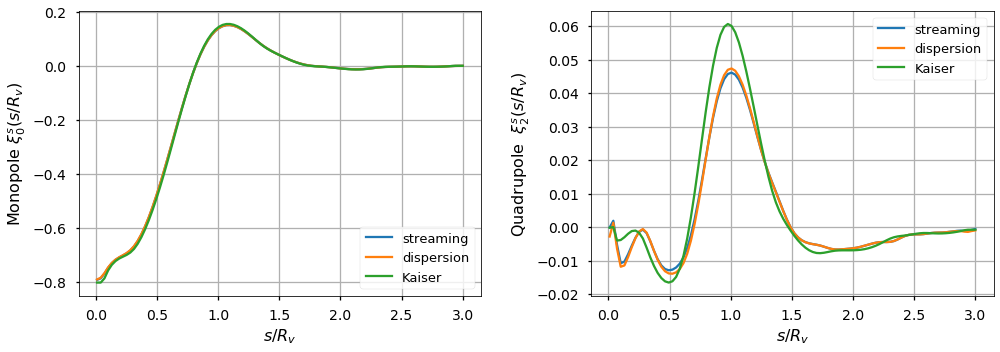

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0, 'options': {'rsd_model': 'streaming'}, 'label': 'streaming'}
params2 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0, 'options': {'rsd_model': 'dispersion'}, 'label': 'dispersion'}
params3 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0, 'options': {'rsd_model': 'kaiser'}, 'label': 'Kaiser'}
s = np.linspace(0.01, 3, 100)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax1, ell=0, **{'xlabel': r'$s/R_v$', 'ylabel': r'Monopole $\xi^s_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax2, ell=2, **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

The effect of including the full velocity pdf is to suppress anisotropies (e.g. leading to smaller quadrupole variations) and to very slightly shift the distance scale at which they occur. Differences in the quadrupole from approximating the pdf as a delta function are obvious, but in the monopole they are harder to see because of the dynamic range of plot. This can be rectified by plotting the monopole as the difference to the real-space input instead:

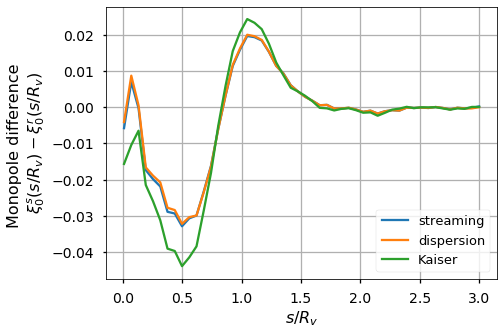

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
s = np.linspace(0.01, 3)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax, diff=True, ell=0, **{'xlabel': r'$s/R_v$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s/R_v)-\xi^r_0(s/R_v)$'})
ax.legend(loc='lower right')
ax.xaxis.get_label().set_fontsize(16)
ax.yaxis.get_label().set_fontsize(16)
ax.tick_params(labelsize=14)
ax.grid()

## RSD model comparison 2: different Kaiser model options

Now while restricting to the Kaiser model scenario let's compare the full expression with the two additional approximations.

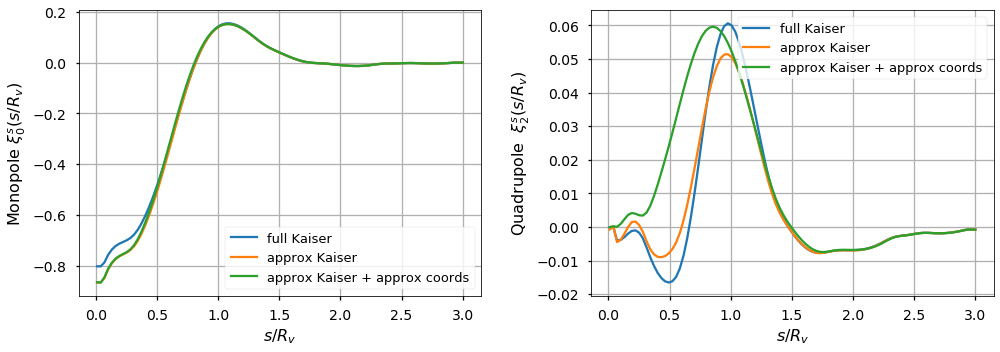

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0, 'M': 1.0, 'Q': 1.0,
           'options': {'rsd_model': 'kaiser'}, 'label': 'full Kaiser'}
params2 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0,  'M': 1.0, 'Q': 1.0,
           'options': {'rsd_model': 'kaiser', 'kaiser_approximation': True}, 'label': 'approx Kaiser'}
params3 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0,  'M': 1.0, 'Q': 1.0,
           'options': {'rsd_model': 'kaiser', 'kaiser_approximation': True, 'kaiser_coord_shift': False}, 
           'label': 'approx Kaiser + approx coords'}
s = np.linspace(0.01, 3, 100)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax1, ell=0, **{'xlabel': r'$s/R_v$', 'ylabel': r'Monopole $\xi^s_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax2, ell=2, **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

Clearly each additional approximation has a large effect on the result, i.e. the terms neglected in each case are not really small.


## Accounting for anisotropy in the real-space input

In all of the model expressions described above [Equations (1), (3), (4), (6), (8-10)] I wrote the real-space CCF as $\xi^r(\mathbf{r})$ for generality. In most papers however this is *assumed* to be isotropic, $\xi^r(\mathbf{r})=\xi^r(r)$. In principle, in a statistically homogeneous and isotropic Universe, if the sample of voids/DS centres used to determine $\xi^r$ is large enough to suppress noise and no direction-dependent selection effects influence the choice of that sample, the real-space CCF must be isotropic, $\xi^r(\mathbf{r})=\xi^r(r)$. In practice however, this will generally **not** to be true because of:

1. The Alcock-Paczynski effect: if the fiducial cosmology differs from the truth, anisotropies are introduced to *both* $\xi^r$ and $\xi^s$
2. Selection effects: if the sample of voids/DS centres is selected based on operations on the redshift-space galaxy field, structures aligned along the line of sight are preferentially selected, producing an "intrinsic" distortion to $\xi^r$
3. Imperfect reconstruction: where reconstruction is used prior to void-finding to counter selection effects, 

      (a) the assumed reconstruction parameter $\beta=f/b$ may differ from the truth (will definitely differ from the truth if many different values of $\beta$ are used!) and/or 

      (b) reconstruction may not be (is not) perfect. 
    
    This can leave residual selection effect contributions as well as leading to residual anisotropies in the estimate of $\xi^r$ using the reconstructed galaxy positions (similar to the AP effect).

If you have anisotropy information (e.g. measured quadrupole moment) present for the real-space CCF, you can tell `victor` whether to use the more general expressions or to ignore the anisotropy by setting the value of `model['assume_isotropic']` (default `True`). You can see the effect of this in the example in the `victor_usage_demo.ipynb` notebook. 

In the current example data only the input real-space CCF monopole is supplied, so toggling this model choice will make no difference to the output.

# 2. Matter profile model options

In the default settings for `victor`, the key velocity profile $v_r(r)$ appearing in all equations above is assumed to be determined by the enclosed matter density profile

$$v_r(r) = -frac{1}{3}faHr\Delta(r)$$

where $\Delta(r)$ is related to the void-matter or DS-matter CCF $\delta(r)$ (i.e. the density contrast in a shell at radius $r$) by $\Delta(r)=\frac{3}{r^3}\int_0^ry^2\delta(y)\,\mathrm{d}y$. Thus the choice of how to model $\delta(r)$ or $\Delta(r)$ will affect the model results for $\xi^s$.

## Linear bias model

A commonly used model choice is to assume that the CCF with matter is related to the CCF with galaxies by a single constant linear bias,

$$\delta(r) = \frac{1}{b}\xi^r_0(r),\;\;\;\;\;\;(11)$$

and similarly $\Delta(r)=\overline{\xi^r_0(r)}/b$. In `victor` this option can be chosen as the default by setting `model['matter_ccf']['model']='linear_bias` during initialisation, or temporarily by passing kwarg `{'matter_model'='linear_bias'}` to the model evaluation call. Choosing this option means that the RSD model evaluation depends only on the parameter $\beta=f/b$ and not on $f\sigma_8$.

## Template model

Alternatively, a template of $\delta(r)$ or $\Delta(r)$ can be supplied during initialisation (see more detailed instructions in `victor_usage_demo.ipynb`). This option can only be used if `model['matter_ccf']['model']='template` was set during initialisation and appropriate template information was provided in the model input file. In this case the amplitude of the template is varied according to $\sigma_8$ so the RSD model depends on parameter $f\sigma_8$ (potentially as well as on $\beta$ if reconstruction was used).


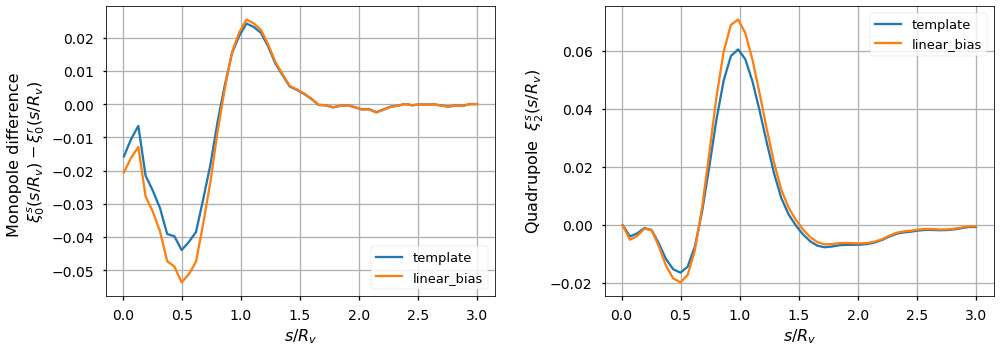

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.47, 'epsilon': 1.0,
           'options': {'rsd_model': 'kaiser'}, 'label': 'template'}
params2 = {'beta': 0.4, 'epsilon': 1.0,
           'options': {'rsd_model': 'kaiser', 'matter_model': 'linear_bias'}, 'label': 'linear_bias'}
s = np.linspace(0.01, 3)
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax1, diff=True, ell=0, **{'xlabel': r'$s/R_v$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s/R_v)-\xi^r_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax2, ell=2, **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)


## Excursion set model

[Massara & Sheth (2018)](https://arxiv.org/abs/1811.03132) provided a model to describe $\Delta(r)$ around voids from first principles in the excursion set formalism. This model depends on the matter power spectrum and thus cosmological parameters like $\Omega_M$, as well as on 4 nuisance parameters $b_{10}$, $b_{01}$, $R_p$ and $R_x$ (fuller decription to be provided elsewhere). This option can be used by setting `model['matter_ccf']['model']='excursion_set` during initialisation, or temporarily by passing kwarg `{'matter_model': 'excursion_set'}` to the model evaluation call.

*This model cannot be used when distances are specified in units of the void radius as done in this example notebook.*

# 3. Mean velocity model options

Finally, `victor` allows different options for modelling the relationship between velocity profile $v_r(r)$ and $\Delta(r)$.

## Linear model

This is the simplest and most commonly used: $v_r(r) = -\frac{1}{3}faHr\Delta(r)$. This is set by `model['velocity_pdf']['mean']['model']='linear'` at initialisation, or by passing the kwarg `{'mean_model': 'linear'}` at runtime.

## Empirical correction term

This describes a multiplicative correction factor $v_r^\mathrm{corr}(r) = \left[1 + A_v\delta(r)\right]v_r(r)$. It therefore has one additional free parameter, $A_v$ (which defaults to 0 if not explicitly provided).

The reason for including of this empirical correction in some papers is the observation that sometimes in simulations galaxy velocities close to the centre of the void/DS region are not very well modelled by other expressions, even though the modelling works well at larger distances. The form of this correction formally differs from that first introduced by [Paillas *et al*. (2021)](https://arxiv.org/abs/2101.09854), but in practice numerically almost identical outcomes can be achieved by varying $A_v$ (and I think this version is slightly easier to motivate/understand).

## Non-linear model

This is a fully non-linear model derived from the excursion set model of [Massara & Sheth (2018)](https://arxiv.org/abs/1811.03132) (+ later extensions). It will be described fully elsewhere. It can only be used if the matter CCF model choice is `'excursion_set'` (see above): then it can be chosen by setting `model['velocity_pdf']['mean']['model']='nonlinear'` at initialisation, or by passing the kwarg `{'mean_model': 'nonlinear'}` at runtime.

### Comparison of velocity profiles with an without empirical correction:

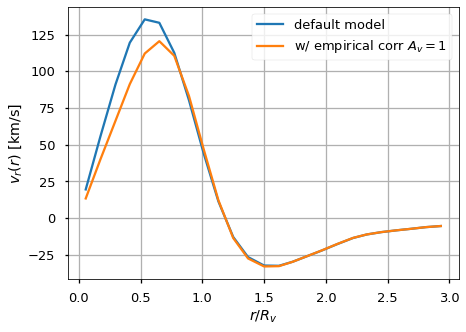

In [8]:
params = {'fsigma8': 0.47, 'epsilon': 1.0, 'Av': 1}
# since distances here are in units of void radius, need to add this back in
Rv = 50 # same assumption as before
vr, deriv_vr = ccf.velocity_terms(ccf.r, params)
plt.figure(figsize=(7,5))
plt.plot(ccf.r, vr*Rv, label=r'default model')
vr, deriv_vr = ccf.velocity_terms(ccf.r, params, **{'empirical_corr': True}) 
plt.plot(ccf.r, vr*Rv, label=rf'w/ empirical corr $A_v={params["Av"]}$')
plt.legend(loc='upper right')
plt.xlabel(r'$r/R_v$')
plt.ylabel(r'$v_r(r)$ [km/s]')
plt.grid()

### Comparison of RSD model with and without empirical correction:

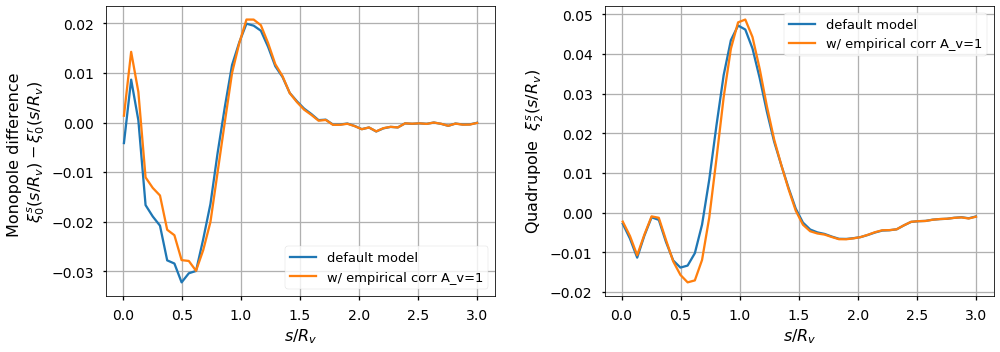

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
params1 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0,
           'options': {'rsd_model': 'dispersion'}, 'label': 'default model'}
params2 = {'fsigma8': 0.47, 'sigma_v': 7, 'epsilon': 1.0, 'Av': 1,
           'options': {'rsd_model': 'dispersion', 'empirical_corr': True}, 'label': 'w/ empirical corr A_v=1'}

s = np.linspace(0.01, 3)
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax1, diff=True, ell=0, 
                          **{'xlabel': r'$s/R_v$', 'ylabel': 'Monopole difference \n' + r'$\xi^s_0(s/R_v)-\xi^r_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, s=s, ax=ax2, ell=2, 
                          **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
for ax in [ax1, ax2]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

Note how what appears to be quite a large change in the $v_r$ profile is not actually such a big difference in the final RSD result!

# Interesting side note

By setting the `matter_model` option to `linear_bias` and using the reported parameter values $\beta=0.347$, $\epsilon=1.0058$, $\mathcal{M}=1.138$ and $\mathcal{Q}=1.22$, we should be able to reproduce the results shown in Figure 5 of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) for the "approximate Kaiser" model. However we actually obtain the following:

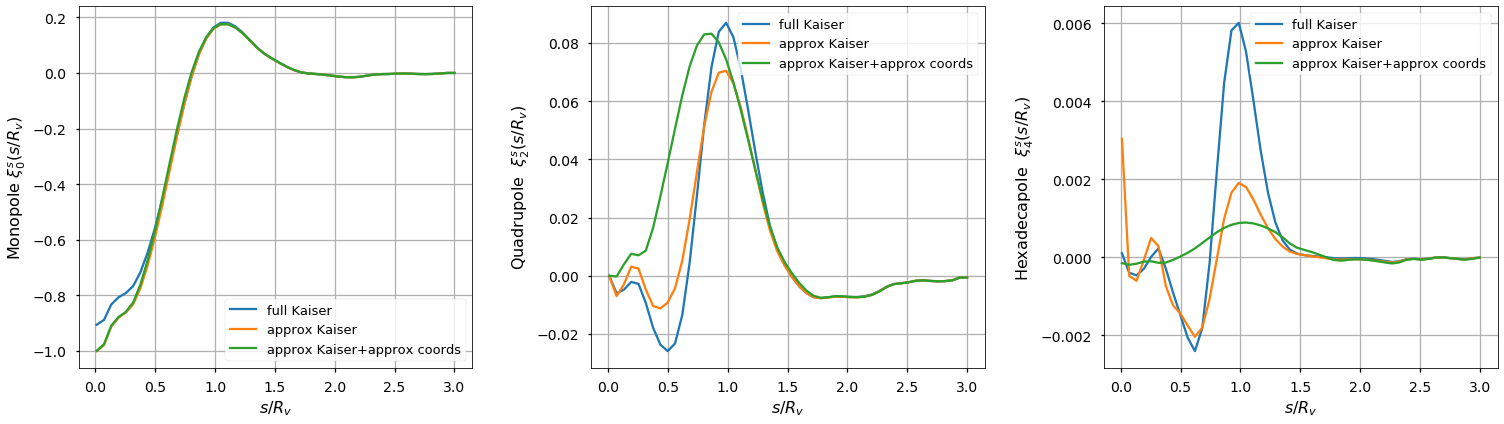

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
params1 = {'beta': 0.347, 'epsilon': 1.0058, 'M': 1.138, 'Q': 1.22,
           'options': {'rsd_model': 'kaiser', 'matter_model': 'linear_bias'}, 'label': 'full Kaiser'}
params2 = {'beta': 0.347, 'epsilon': 1.0058, 'M': 1.138, 'Q': 1.22,
           'options': {'rsd_model': 'kaiser', 'kaiser_approximation': True, 'matter_model': 'linear_bias'}, 
           'label': 'approx Kaiser'}
params3 = {'beta': 0.347, 'epsilon': 1.0058, 'M': 1.138, 'Q': 1.22,
           'options': {'rsd_model': 'kaiser', 'kaiser_approximation': True, 
                       'kaiser_coord_shift': False, 'matter_model': 'linear_bias'}, 
           'label': 'approx Kaiser+approx coords'}
s = np.linspace(0.01, 3)
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax1, ell=0, **{'xlabel': r'$s/R_v$', 'ylabel': r'Monopole $\xi^s_0(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax2, ell=2, **{'xlabel': r'$s/R_v$', 'ylabel': r'Quadrupole  $\xi^s_2(s/R_v)$'})
ccf.plot_model_multipoles(params1, params2, params3, s=s, ax=ax3, ell=4, **{'xlabel': r'$s/R_v$', 'ylabel': r'Hexadecapole  $\xi^s_4(s/R_v)$'})
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
for ax in [ax1, ax2, ax3]:
    ax.xaxis.get_label().set_fontsize(16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.tick_params(labelsize=14)
    ax.grid()
plt.tight_layout(w_pad=3)

Careful comparison against Figure 5 of [Hamaus *et al*. 2020](https://arxiv.org/abs/2007.07895) shows that their results best match those labelled here as "approx Kaiser + approx coords" – this is clearest from the quadrupole moment at $s\sim0.5R_v$. This suggests that Hamaus *et al* have actually not implemented exactly the model described in their paper: in particular that they do not seem to have correctly applied the full coordinate transformation (Equation (7) in this notebook, inline equation following Eq. (3.8) in their paper).

It is also clear that even if this had been correctly applied, the approximation involved in the "approximate Kaiser" model is not a good one.